# Feature Selection
This material is adapted from the following,
- [Scikit Learn](http://scikit-learn.org/stable/)  
- [Sebastian Raschka](https://github.com/rasbt/python-machine-learning-book)  
- [Jake Vanderplas](https://github.com/jakevdp/sklearn_tutorial)
- [Andreas Mueller](http://amueller.github.io)  
- [Kyle Kastner](https://kastnerkyle.github.io/)  
- [Quantopian Research](https://github.com/quantopian/research_public)
- [Python for Probability, Statistics, and Machine Learning](http://www.springer.com/fr/book/9783319307152), [github](https://github.com/unpingco/Python-for-Probability-Statistics-and-Machine-Learning)

## Imports

In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%load_ext line_profiler

# Ignore Warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

from helper_functions import tic, toc

""" Include Parent Directory in Python Path """
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

In [5]:
from IPython.display import Image
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (10, 6)

# Notes for today's class

## Note on imputation
If you need to impute data, you have several options with Pandas. A very nice purpose-specific library to consider is [FancyImpute](https://pypi.python.org/pypi/fancyimpute/0.0.4). 

## Note on Categorical/Qualitative Data
A common way to deal with categorical/qualitative data is to "onehotencode" the classes/categories. This is available in scikit-learn.

## Training-Test Splitting
Scikit-Learn provides several "Cross-Validation" approaches. For now, it's best to stick to the [train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function. 

More detail on more advanced techniques will be provided in the class on Model Evaluation.

## Feature Scaling
Many algorithms benefit from features that are appropriately scaled. Many [scaling functions](http://scikit-learn.org/stable/modules/preprocessing.html) are available in Scikit-Learn. 

## Feature Selection
[This](http://blog.datadive.net/selecting-good-features-part-i-univariate-selection/) series of posts provides a comprehensive review of feature selection approaches. 

[mlxtend](http://rasbt.github.io/mlxtend/) provides several good [sequential feature selection](http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/#sequential-feature-selector) algorithms you should be familiar with.

# Regularization
The idea behind regularization is to prefer simpler models for a certain definition of ''simpler'', even if they lead to more errors on the training set.

Regularization can also be viewed as a prior on the distribution from which your data is drawn (most famously Gaussian for least-squares), as a way to punish high values in regression coefficients, and so on.

First, let's understand Projection,

## Projection

The concept of projection is key to developing an intuition about regularization. We already have a natural intuition of projection from looking at the shadows of objects on a sunny day. Consider the following figure:
<img src="../images/probability_001.png" width=500>

Our aim is to find a point along the blue line (namely, $\mathbf{x}$) that is closest to the black square (namely, $\mathbf{y}$). In other words, we want to inflate the gray circle until it just touches the black line. Recall that the circle boundary is the set of points for which
$$
\sqrt{(\mathbf{y}-\mathbf{x})^T(\mathbf{y}-\mathbf{x})} =\|\mathbf{y}-\mathbf{x} \| = \epsilon
$$

 for some value of $\epsilon$. So we want a point $\mathbf{x}$ along
the line that satisfies this for the smallest $\epsilon$.  Then, that point
will be the closest point on the black line to the black square.
 It may be obvious from the diagram, but the closest point on the line
occurs where the line segment from the black square to the black line is
perpedicular to the line. At this point, the gray circle just touches the black
line.

Given the point $\mathbf{y}$ (black square) we want to find the $\mathbf{x}$ along the line that is closest to it. The gray circle is the locus of points within a fixed distance from $\mathbf{y}$.

The line tangent to the circle is the closest point on the line.

<img src="../images/probability_002.png" width=500>

We can analytically solve for an arbitrary point along the black line as:

$$
\mathbf{x}=\alpha\mathbf{v}
$$

where $\alpha\in\mathbb{R}$ slides the point up and down the line with
 
$$
\mathbf{v} = \left[ 1,1 \right]^T
$$

Formally, $\mathbf{v}$ is the *subspace* onto which we want to *project* $\mathbf{y}$. At the closest point, the vector between $\mathbf{y}$ and $\mathbf{x}$ (the *error* vector above) is
perpedicular to the line. This means that

$$
(\mathbf{y}-\mathbf{x} )^T \mathbf{v} = 0
$$

and through substitution and basic algebra, we obtain
 
$$
\alpha = \frac{\mathbf{y}^T\mathbf{v}}{ \|\mathbf{v} \|^2}
$$

The *error* is the distance between $\alpha\mathbf{v}$ and $\mathbf{y}$.  This is a right triangle, and we can use the Pythagorean theorem to compute the squared length of this error as

$$
\epsilon^2 = \|( \mathbf{y}-\mathbf{x} )\|^2 = \|\mathbf{y}\|^2 - \alpha^2 \|\mathbf{v}\|^2 = \|\mathbf{y}\|^2 - \frac{\|\mathbf{y}^T\mathbf{v}\|^2}{\|\mathbf{v}\|^2}
$$

where $ \|\mathbf{v}\|^2 = \mathbf{v}^T \mathbf{v} $. Note that since $\epsilon^2 \ge 0 $, this also shows that
 
$$
\| \mathbf{y}^T\mathbf{v}\| \le \|\mathbf{y}\|  \|\mathbf{v}\|
$$

which is the famous and useful Cauchy-Schwarz inequality. Finally, we can assemble all of this into the *projection* operator

$$
\mathbf{P}_v = \frac{1}{\|\mathbf{v}\|^2 } \mathbf{v v}^T
$$

With this operator, we can take any $\mathbf{y}$ and find the closest point on $\mathbf{v}$ as

$$
\mathbf{P}_v \mathbf{y} = \mathbf{v} \left( \frac{  \mathbf{v}^T \mathbf{y} }{\|\mathbf{v}\|^2} \right)
$$

where we recognize the term in parenthesis as the $\alpha$ we computed earlier. It's called an *operator* because it takes a vector ($\mathbf{y}$) and produces another vector ($\alpha\mathbf{v}$). Thus, projection unifies geometry and optimization.

## Weighted distance

We can easily extend this projection operator to cases where the measure of
distance between $\mathbf{y}$ and the subspace $\mathbf{v}$ is weighted. We can
accommodate these weighted distances by re-writing the projection operator as

<!-- Equation labels as ordinary links -->
<div id="eq:weightedProj"></div>

$$
\mathbf{P}_v=\mathbf{v}\frac{\mathbf{v}^T\mathbf{Q}^T}{\mathbf{v}^T\mathbf{Q v}}
$$

 where $\mathbf{Q}$ is positive definite matrix.  In the previous
case, we started with a point $\mathbf{y}$ and inflated a circle centered at
$\mathbf{y}$ until it just touched the line defined by $\mathbf{v}$ and this
point was closest point on the line to $\mathbf{y}$. The same thing happens
in the general case with a weighted distance except now we inflate an
ellipse, not a circle, until the ellipse touches the line.

In the weighted case, the closest point on the line is tangent to the ellipse and is still perpedicular in the sense of the weighted distance.

<img src="../images/probability_003.png" width=500>

Note that the error vector ($\mathbf{y}-\alpha\mathbf{v}$) is still perpendicular to the line (subspace $\mathbf{v}$), but in the space of the weighted distance. The difference between the first projection (with the uniform circular distance) and the general case (with the elliptical weighted distance) is the inner product between the two cases.  For example, in the first case we have $\mathbf{y}^T \mathbf{v}$ and in the weighted case we have $\mathbf{y}^T \mathbf{Q}^T \mathbf{v}$. To move from the uniform circular case to the weighted ellipsoidal case, all we had to do was change all of the vector inner products. Before we finish, we need a formal property of projections:

$$
\mathbf{P}_v \mathbf{P}_v = \mathbf{P}_v
$$

known as the *idempotent* property which basically says that once we have projected onto a subspace, subsequent projections leave us in the same subspace. Thus, projection ties a minimization problem (closest point to a line) to an algebraic concept (inner product).

## The ℓp Ball
As the value of p decreases, the size of the corresponding ℓp space also decreases. This can be seen visually when comparing the the size of the spaces of signals, in three dimensions, for which the ℓp norm is less than or equal to one. The volume of these ℓp “balls” decreases with p.

<img src="../images/main-qimg-517abeaca4e28655ba0a8d694a2a308f.png" width=600>

The most common choice of regularizers are ℓ1 

<img src="../images/04_13.png" width=600>

and ℓ2 

<img src="../images/04_12.png" width=600>

Typically ridge or ℓ2 penalties are much better for minimizing prediction error rather than ℓ1 penalties. The reason for this is that when two predictors are highly correlated, ℓ1 regularizer will simply pick one of the two predictors. In contrast, the ℓ2 regularizer will keep both of them and jointly shrink the corresponding coefficients a little bit. Thus, while the ℓ1 penalty can certainly reduce overfitting, you may also experience a loss in predictive power.

ℓ2 penalization is preferable for data that is not at all sparse, i.e. where you do not expect regression coefficients to show a decaying property. In such cases, incorrectly using an ℓ1 penalty for non-sparse data will give you give you a large estimation error. If the true signal is sparse its coefficients have exactly k non-zero elements and approximately sparse if k really large coefficients and with the rest of the coefficients decaying quickly to zero. ℓ1 regularization doesn't merely encourage sparse solutions, but is capable of exact recovery of sparse signals.

## Practicel Example of Regularization
Now that the theoretical foundation of regularization is clear, let's look at an example.

First, let's generate with a 9th order polynomial.

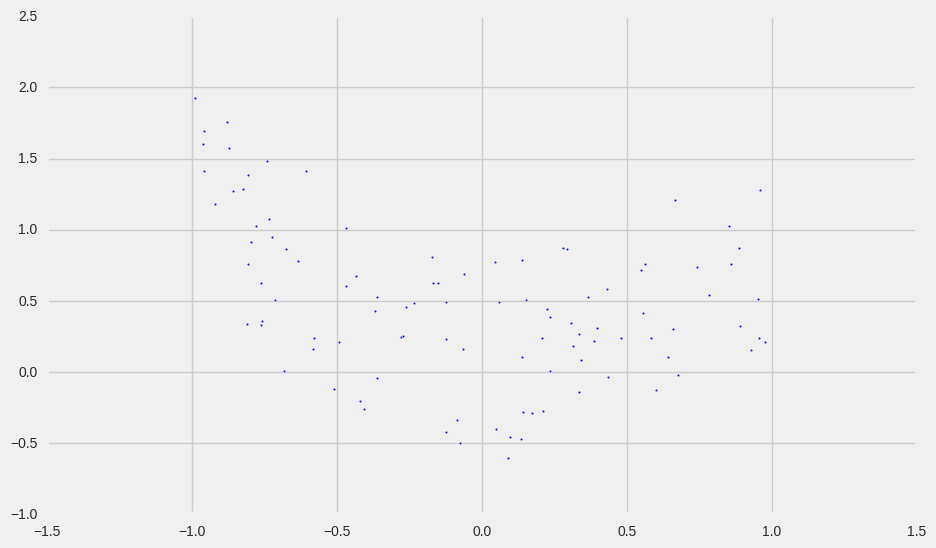

In [6]:
rng = np.random.RandomState(0)
x = 2 * rng.rand(100) - 1

f = lambda t: 1.2 * t ** 2 + .1 * t ** 3 - .4 * t ** 5 - .5 * t ** 9
y = f(x) + .4 * rng.normal(size=100)

plt.figure()
plt.scatter(x, y, s=4);

And now, let's fit a 4th order and a 9th order polynomial to the data. For this we need to engineer features: the n_th powers of x:

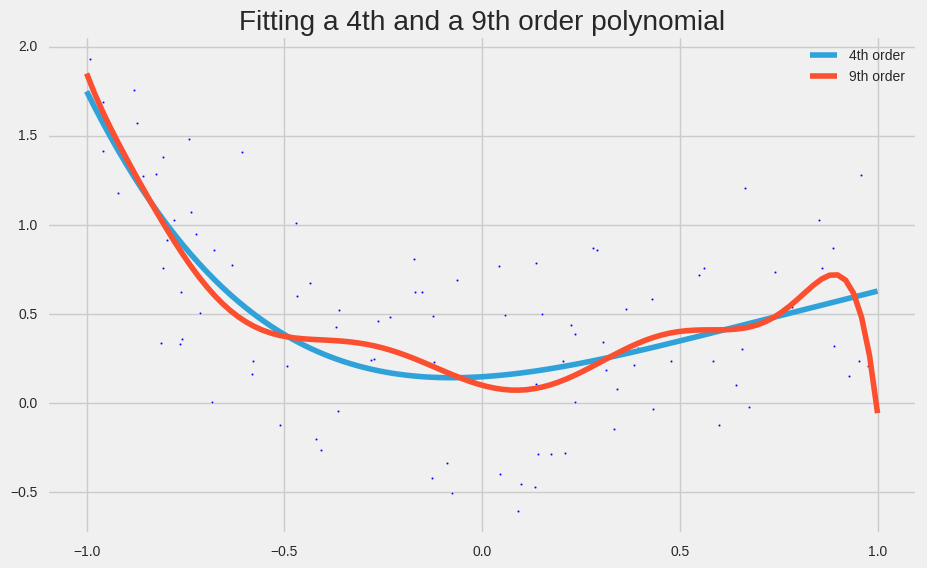

In [7]:
from sklearn.linear_model import LinearRegression

x_test = np.linspace(-1, 1, 100)

plt.figure()
plt.scatter(x, y, s=4)

X = np.array([x**i for i in range(5)]).T
X_test = np.array([x_test**i for i in range(5)]).T
order4 = LinearRegression()
order4.fit(X, y)
plt.plot(x_test, order4.predict(X_test), label='4th order')

X = np.array([x**i for i in range(10)]).T
X_test = np.array([x_test**i for i in range(10)]).T
order9 = LinearRegression()
order9.fit(X, y)
plt.plot(x_test, order9.predict(X_test), label='9th order')

plt.legend(loc='best')
plt.axis('tight')
plt.title('Fitting a 4th and a 9th order polynomial')

Intuitively, which model generalizes better? 

Let's look at the ground truth:

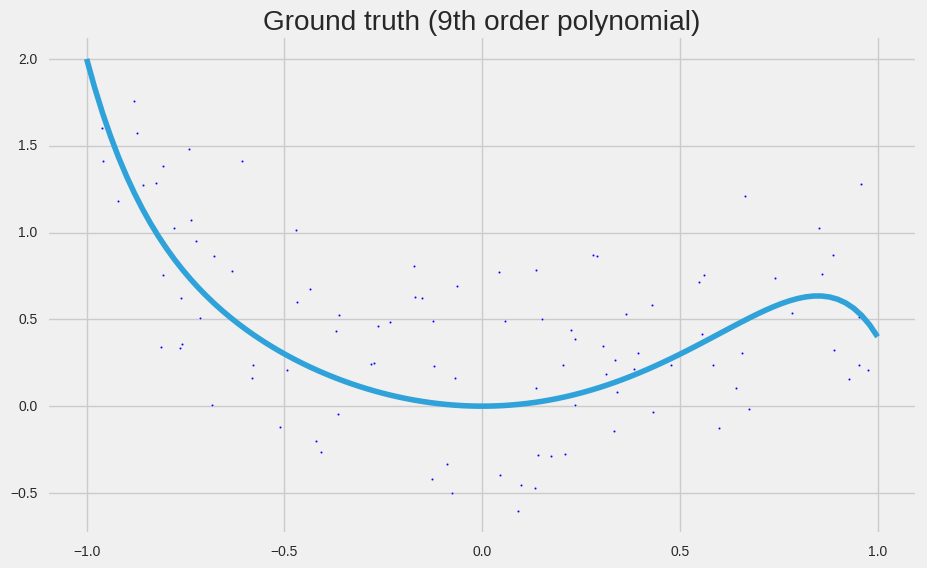

In [9]:
plt.figure()
plt.scatter(x, y, s=4)
plt.plot(x_test, f(x_test), label="truth")
plt.axis('tight')
plt.title('Ground truth (9th order polynomial)');

# Unsupervised Learning

In **Unsupervised Learning** there is no desired output associated with the data.
Instead, we are interested in extracting some form of knowledge or model from the given data.
In a sense, you can think of unsupervised learning as a means of discovering labels from the data itself.
Unsupervised learning is often harder to understand and to evaluate.

Unsupervised learning comprises tasks such as *dimensionality reduction*, *clustering*, and
*density estimation*. For example, in the iris data discussed above, we can used unsupervised
methods to determine combinations of the measurements which best display the structure of the
data. As we’ll see below, such a projection of the data can be used to visualize the
four-dimensional dataset in two dimensions. Some more involved unsupervised learning problems are:

- Given detailed observations of distant galaxies, determine which features or combinations of
  features summarize best the information.
- Given a mixture of two sound sources (for example, a person talking over some music),
  separate the two (this is called the [blind source separation](http://en.wikipedia.org/wiki/Blind_signal_separation) problem).
- Given a video, isolate a moving object and categorize in relation to other moving objects which have been seen.
- Given a large collection of news articles, find recurring topics inside these articles.
- Given a collection of images, cluster similar images together (for example to group them when visualizing a collection)

Sometimes the two may even be combined: e.g. unsupervised learning can be used to find useful
features in heterogeneous data, and then these features can be used within a supervised
framework. This is quite common in successful Kaggle solutions.

## Principal Component Analysis (PCA)
Principal Component Analysis (PCA) is a dimension reduction technique that can find the combinations of variables that explain the most variance.

The following links provide insight into PCA:
- [PCA Explained Visually](http://setosa.io/ev/principal-component-analysis/)
- [Eigenvectors/Eigenvalues explained Visually](http://setosa.io/ev/eigenvectors-and-eigenvalues/)

### Key Equation: $Ax = \lambda b ~~ \text{for} ~~ n \times n $

PCA is an orthogonal linear transformation that transforms the data to a new coordinate system such that the greatest variance by some projection of the data comes to lie on the first coordinate (called the first principal component), the second greatest variance on the second coordinate, and so on. This is an Unsupervised Learning Techniques - Which means we don't have a target variable.


For example, given the following points,

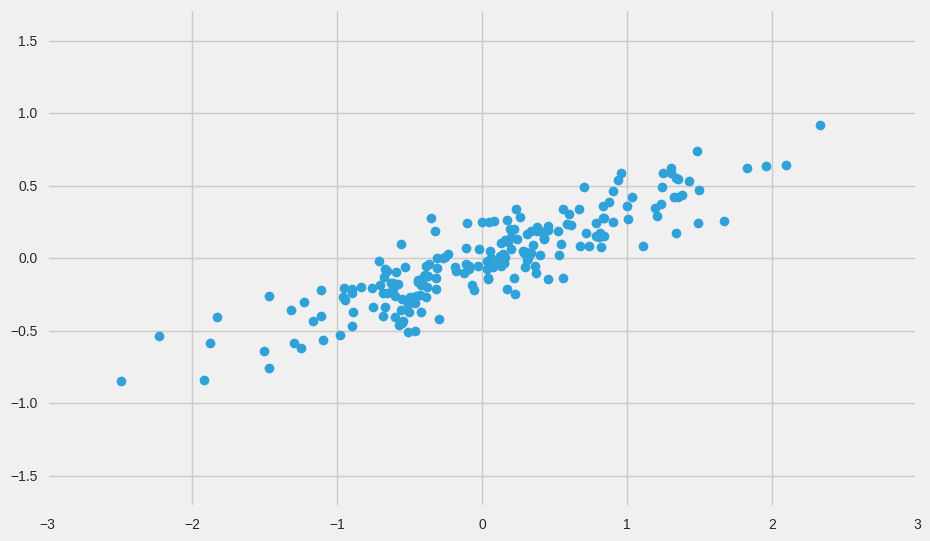

In [52]:
np.random.seed(1)
X = np.dot(np.random.random(size=(2, 2)), np.random.normal(size=(2, 200))).T
plt.plot(X[:, 0], X[:, 1], 'o')
plt.axis('equal');

PCA can be used to find the 2 pricipal components that capture the most variance in the point cloud. In particular, think of PCA as fitting an elipse to the data.

In [53]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

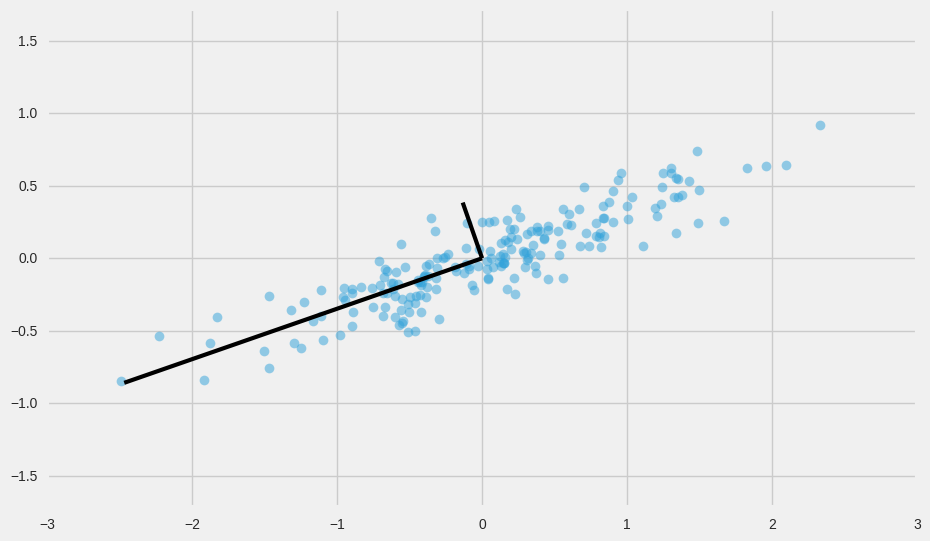

In [54]:
plt.plot(X[:, 0], X[:, 1], 'o', alpha=0.5)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    plt.plot([0, v[0]], [0, v[1]], '-k', lw=3)
plt.axis('equal');

PCA can then be used to retain some desired percentage of variance, while projecting the data down to the 1st component.

In [55]:
clf = PCA(0.95) # keep 95% of variance
X_trans = clf.fit_transform(X)

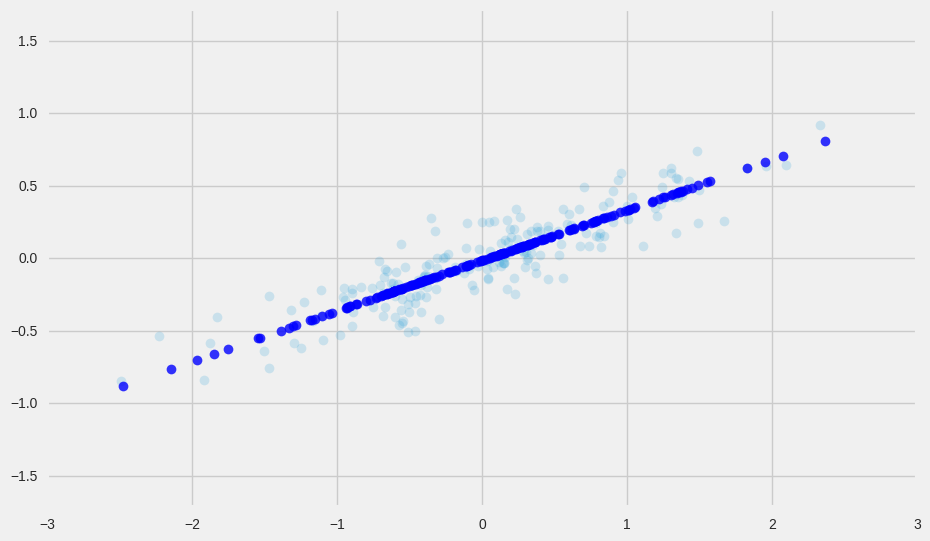

In [56]:
X_new = clf.inverse_transform(X_trans)
plt.plot(X[:, 0], X[:, 1], 'o', alpha=0.2)
plt.plot(X_new[:, 0], X_new[:, 1], 'ob', alpha=0.8)
plt.axis('equal');

## How to choose the number of components
Choosing the most informative number of components can be challenging. Several approaches exist to help.

One approach is to plot the number of components vs the explained variance.

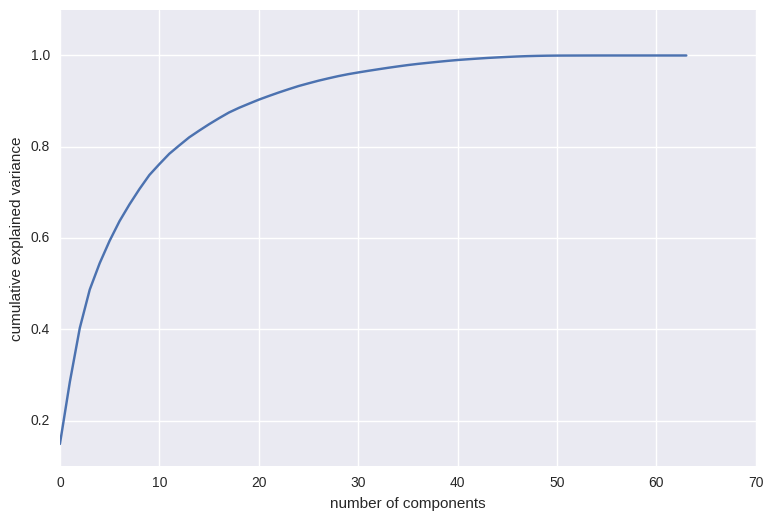

In [58]:
from sklearn.datasets import load_digits
digits = load_digits()
X = digits.data
y = digits.target

sns.set()
pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

Alternatively, for visual data, it might be helpful to plot the information content for an increasing number of components.

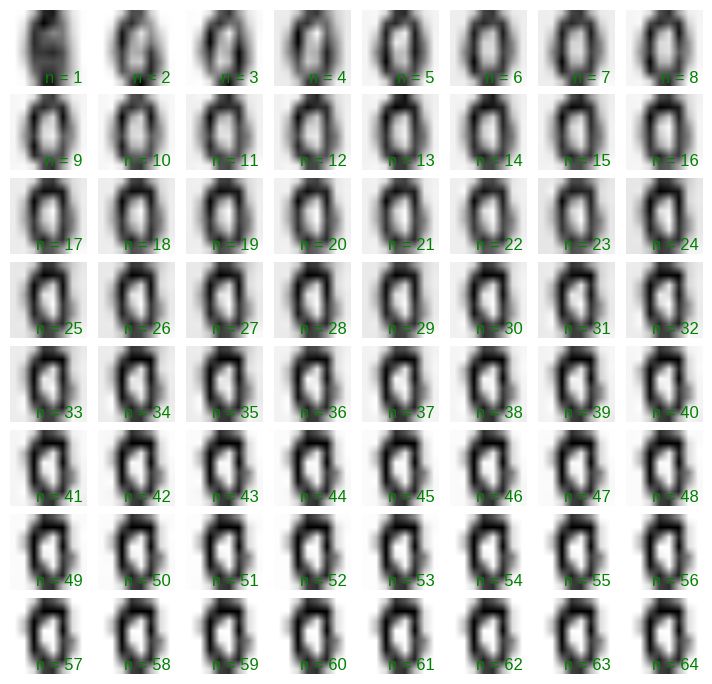

In [59]:
fig, axes = plt.subplots(8, 8, figsize=(8, 8))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for i, ax in enumerate(axes.flat):
    pca = PCA(i + 1).fit(X)
    im = pca.inverse_transform(pca.transform(X[20:21]))

    ax.imshow(im.reshape((8, 8)), cmap='binary')
    ax.text(0.95, 0.05, 'n = {0}'.format(i + 1), ha='right',
            transform=ax.transAxes, color='green')
    ax.set_xticks([])
    ax.set_yticks([])

# Clustering: K-means

Observations that are homogeneous with respect to a given criterion are referred to as ''clusters'' in the data.

Note that these clusters will uncover relevent hidden structure of the data only if the criterion used highlights it.

In [60]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()

K Means is an algorithm for **unsupervised clustering**: that is, finding clusters in data based on the data attributes alone (not the labels).

K Means is a relatively easy-to-understand algorithm.  It searches for cluster centers which are the mean of the points within them, such that every point is closest to the cluster center it is assigned to.

Let's look at how KMeans operates on the simple clusters we looked at previously. To emphasize that this is unsupervised, we'll not plot the colors of the clusters:

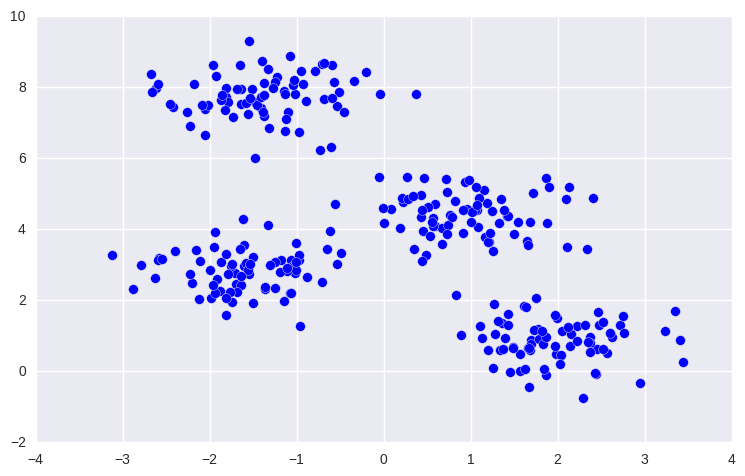

In [61]:
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], s=50);

By eye, it is relatively easy to pick out the four clusters. If you were to perform an exhaustive search for the different segmentations of the data, however, the search space would be exponential in the number of points.

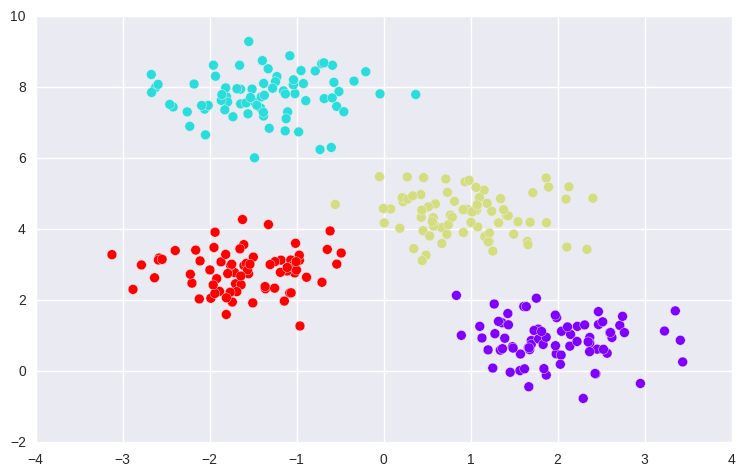

In [62]:
from sklearn.cluster import KMeans
est = KMeans(4)  # 4 clusters
est.fit(X)
y_kmeans = est.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='rainbow');

The algorithm identifies the four clusters of points in a manner very similar to what we would do by eye!

Using *Expectation-Maximization* is another approach to finding clusters in the data. It (often) converges to the optimal cluster centers.

*Expectation-Maximization* is a two-step approach which works as follows:

1. Guess some cluster centers
2. Repeat until converged
   A. Assign points to the nearest cluster center
   B. Set the cluster centers to the mean 

Let's quickly visualize this process:

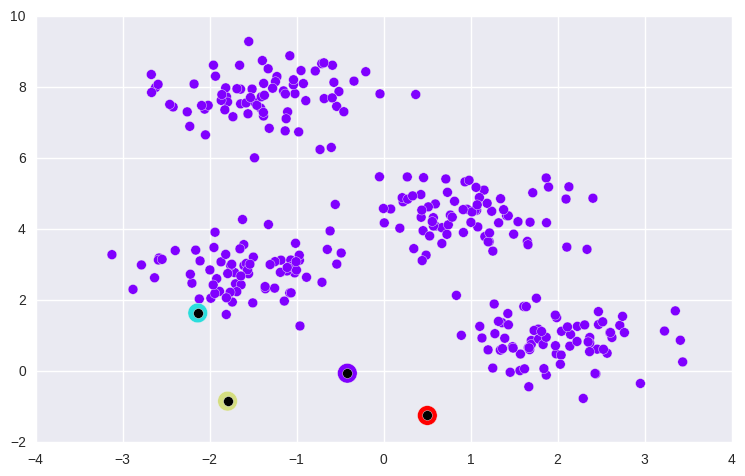

In [63]:
from fig_code import plot_kmeans_interactive
plot_kmeans_interactive();

### KMeans Caveats

The convergence of this algorithm is not guaranteed; for that reason, scikit-learn by default uses a large number of random initializations and finds the best results.

Also, the number of clusters must be set beforehand... there are other clustering algorithms for which this requirement may be lifted.

### The "elbow" method
Another approach is to find the optimal number of clusters using the elbow method.

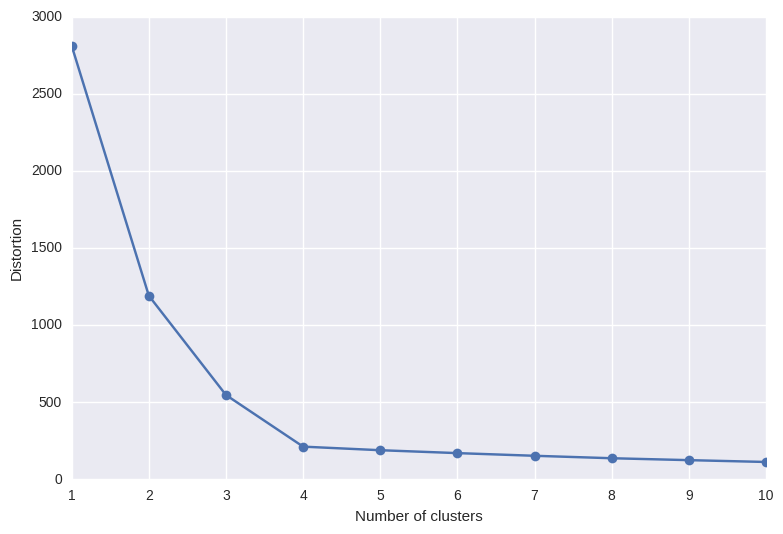

In [64]:
distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i, 
                init='k-means++', 
                n_init=10, 
                max_iter=300, 
                random_state=0)
    km.fit(X)
    distortions.append(km.inertia_)
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.tight_layout()
plt.show()

### Silhouette Plots
Alternatively, one can find the number of clusters through visualizing the number of clusterings/categories.

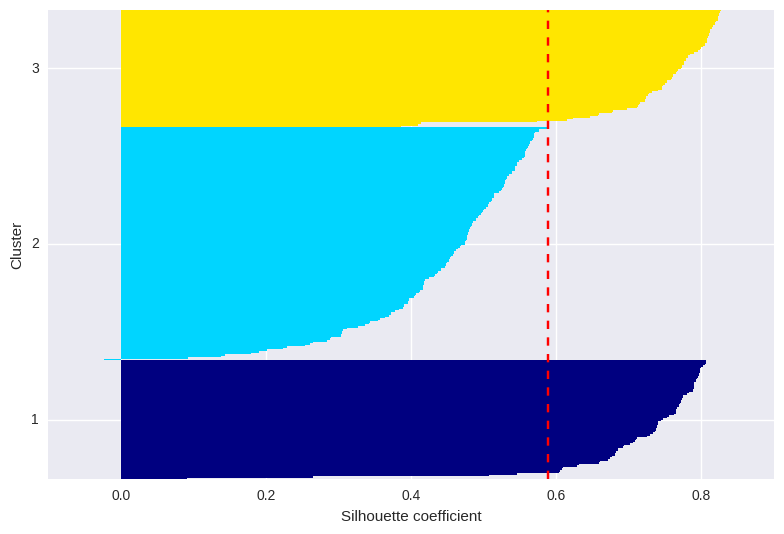

In [65]:
import numpy as np
from matplotlib import cm
from sklearn.metrics import silhouette_samples

km = KMeans(n_clusters=3, 
            init='k-means++', 
            n_init=10, 
            max_iter=300,
            tol=1e-04,
            random_state=0)
y_km = km.fit_predict(X)

cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
             edgecolor='none', color=color)

    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
    
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--") 

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')

plt.tight_layout()

# Answer the following questions:

In [69]:
from IPython.display import HTML
HTML(
"""
<iframe 
	src="https://docs.google.com/a/amirsani.com/forms/d/e/1FAIpQLScan_VpqRwvK1nu31K0CyY6m79QJMB_hQIgGj_9-EJ1mIFB-A/viewform?embedded=true" 
	width="80%" 
	height="1500px" 
	frameborder="0" 
	marginheight="0" 
	marginwidth="0">
	Loading...
</iframe>
"""
)